# Analisis Prediksi Siswa Lulus atau Mengulang

## Kelompok 10
- Taqiyudin Miftah Adn
- Afifah Zuriah Mindarini

## Import Library

In [69]:
!pip install optuna

In [70]:
!pip install catboost

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import catboost as cb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from tabulate import tabulate
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [72]:
!wget -O student_performance.csv "https://raw.githubusercontent.com/TaqiyudinMiftah/10-TaqiyudinMiftahAdn-AfifahZuriahMindarini/main/student_performance.csv"

--2025-03-07 15:59:39--  https://raw.githubusercontent.com/TaqiyudinMiftah/10-TaqiyudinMiftahAdn-AfifahZuriahMindarini/main/student_performance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126366 (123K) [text/plain]
Saving to: ‘student_performance.csv’

student_performance 100%[===================>] 123.40K  --.-KB/s    in 0.04s   

2025-03-07 15:59:40 (3.43 MB/s) - ‘student_performance.csv’ saved [126366/126366]



## Read File Data Info

In [73]:
df = pd.read_csv('student_performance.csv')
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9
1040,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16
1041,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7
1042,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10


In [74]:
df.iloc[:, 0:20]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes
1040,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no
1041,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no
1042,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no


In [75]:
df.iloc[:, 20:33]

,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,yes,no,no,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,yes,no,no,5,5,4,4,5,4,11,9,9,9
1040,yes,yes,no,2,4,5,3,4,2,3,14,16,16
1041,yes,no,no,5,5,3,3,3,3,3,10,8,7
1042,yes,yes,no,4,4,1,3,4,5,0,11,12,10


In [76]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [77]:
df.shape

(1044, 33)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

### Melakukan pengecekan terhadap missing value

In [79]:
df.isnull().sum()

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


In [80]:
df.duplicated().sum()

0

### Menghubah Target kontinu menjadi Binnary Classification

In [81]:
# Mengubah nilai G3 menjadi binnary classification
df['Pass'] = df['G3'].apply(lambda x: 'Mengulang' if x < 10 else 'Lulus')

print(df['Pass'].value_counts())

Pass
Lulus        814
Mengulang    230
Name: count, dtype: int64


Karena G1 dan G2 terlalu mendominasi maka bisa di drop akan meliha peforma asli dari model

In [82]:
# Menghapus kolom G1, G2, dan G3
df = df.drop(columns=['G1', 'G2', 'G3'])

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,Lulus
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,Lulus
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,Lulus
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,Lulus
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,Lulus


## Data Visualitation

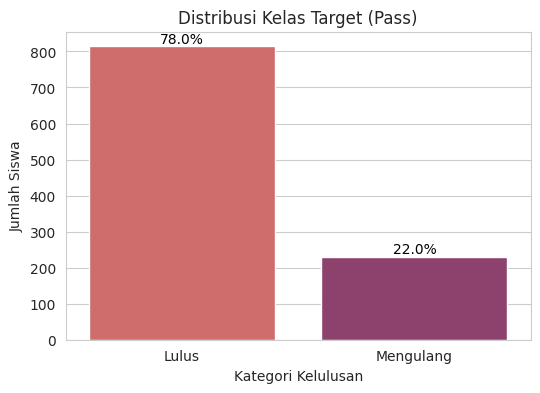

,proportion
Pass,
Lulus,77.969349
Mengulang,22.030651


In [83]:
# Visualisasi distribusi kelas target "Pass"
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="Pass", data=df, palette="flare")
plt.title("Distribusi Kelas Target (Pass)")
plt.xlabel("Kategori Kelulusan")
plt.ylabel("Jumlah Siswa")

# Menambahkan persentase pada masing-masing bar
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# Persentase distribusi kelas
class_distribution = df["Pass"].value_counts(normalize=True) * 100
class_distribution


Siswa yang lulus memiliki jumlah lebih banyak dari tidak lulus, dengan presentase lulus 77.9 % dan tidak lulus 22.03%

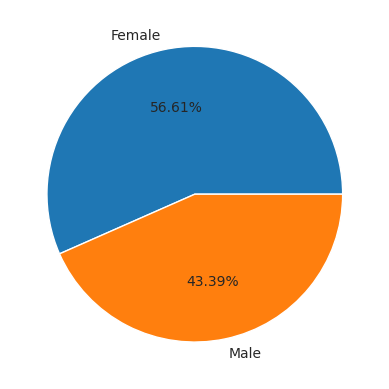

In [84]:
fig, ax = plt.subplots()
Gen_pie = df["sex"].value_counts()
labels = ["Female", "Male"]
ax.pie(Gen_pie, labels=labels, autopct='%2.2f%%')

plt.show()

- Lebih banyak siswa perempuan dibandingkan laki-laki.

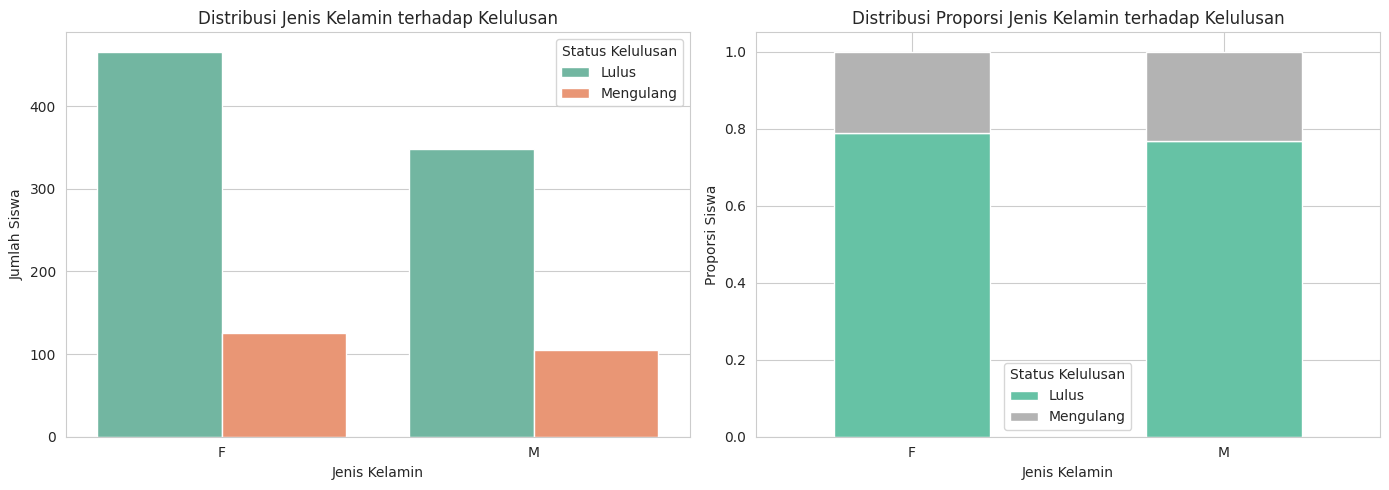

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot jumlah siswa berdasarkan jenis kelamin dan kelulusan
sns.countplot(x="sex", hue="Pass", data=df, palette="Set2", ax=axes[0])
axes[0].set_title("Distribusi Jenis Kelamin terhadap Kelulusan")
axes[0].set_xlabel("Jenis Kelamin")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Normalized barplot (proporsi siswa)
df_sex = df.groupby("sex")["Pass"].value_counts(normalize=True).unstack()
df_sex.plot(kind="bar", stacked=True, colormap="Set2", ax=axes[1])
axes[1].set_title("Distribusi Proporsi Jenis Kelamin terhadap Kelulusan")
axes[1].set_xlabel("Jenis Kelamin")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_sex.index, rotation=0)

plt.tight_layout()
plt.show()

- Siswa perempuan memiliki jumlah kelulusan lebih banyak dibanding lelaki

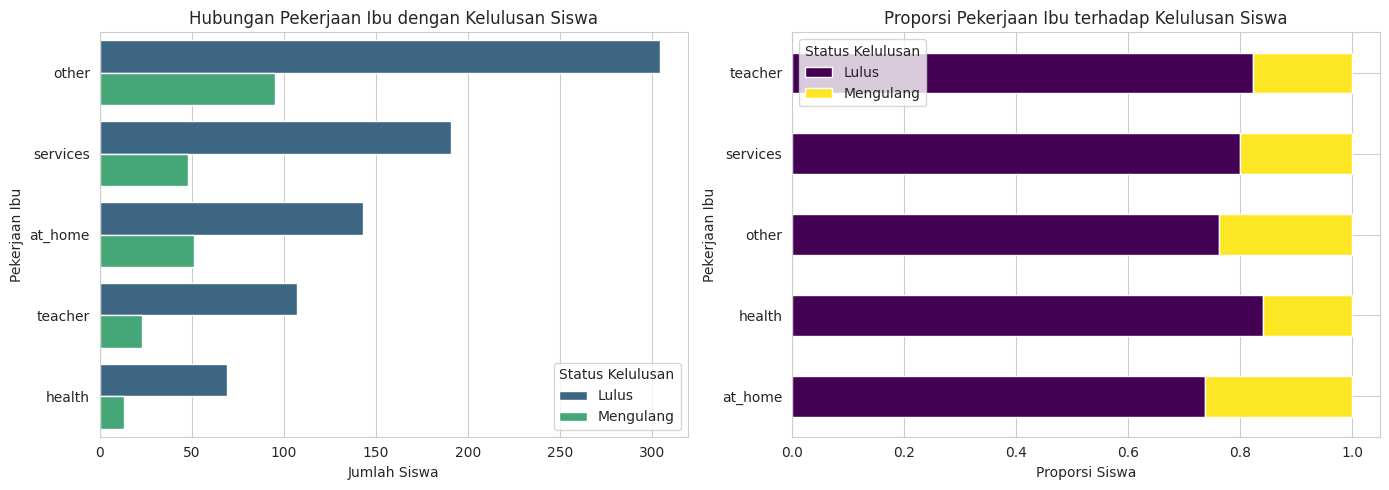

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot jumlah siswa berdasarkan pekerjaan ibu dan kelulusan
sns.countplot(y="Mjob", hue="Pass", data=df, palette="viridis", order=df["Mjob"].value_counts().index, ax=axes[0])
axes[0].set_title("Hubungan Pekerjaan Ibu dengan Kelulusan Siswa")
axes[0].set_ylabel("Pekerjaan Ibu")
axes[0].set_xlabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Normalized barplot (proporsi siswa)
df_mjob = df.groupby("Mjob")["Pass"].value_counts(normalize=True).unstack()
df_mjob.plot(kind="barh", stacked=True, colormap="viridis", ax=axes[1])
axes[1].set_title("Proporsi Pekerjaan Ibu terhadap Kelulusan Siswa")
axes[1].set_ylabel("Pekerjaan Ibu")
axes[1].set_xlabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")

plt.tight_layout()
plt.show()

- Pekerjaan ibu siswa paling banyak adalah di kategori lain-lain (other), diikuti oleh pekerjaan services dan ibu rumah tangga (at_home).

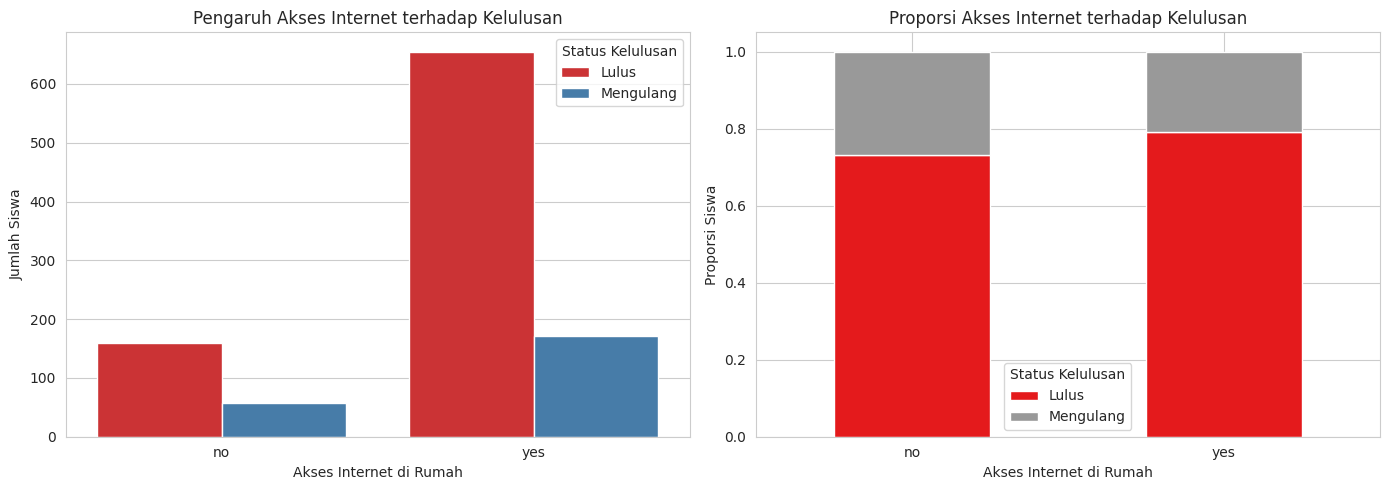

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot jumlah siswa berdasarkan akses internet dan kelulusan
sns.countplot(x="internet", hue="Pass", data=df, palette="Set1", ax=axes[0])
axes[0].set_title("Pengaruh Akses Internet terhadap Kelulusan")
axes[0].set_xlabel("Akses Internet di Rumah")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Normalized barplot (proporsi siswa)
df_internet = df.groupby("internet")["Pass"].value_counts(normalize=True).unstack()
df_internet.plot(kind="bar", stacked=True, colormap="Set1", ax=axes[1])
axes[1].set_title("Proporsi Akses Internet terhadap Kelulusan")
axes[1].set_xlabel("Akses Internet di Rumah")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_internet.index, rotation=0)

plt.tight_layout()
plt.show()


- Siswa yang mendapat akses internet memiliki tinggkat kelulusan lebih tinggi dibanding tidak mendapat akses internet

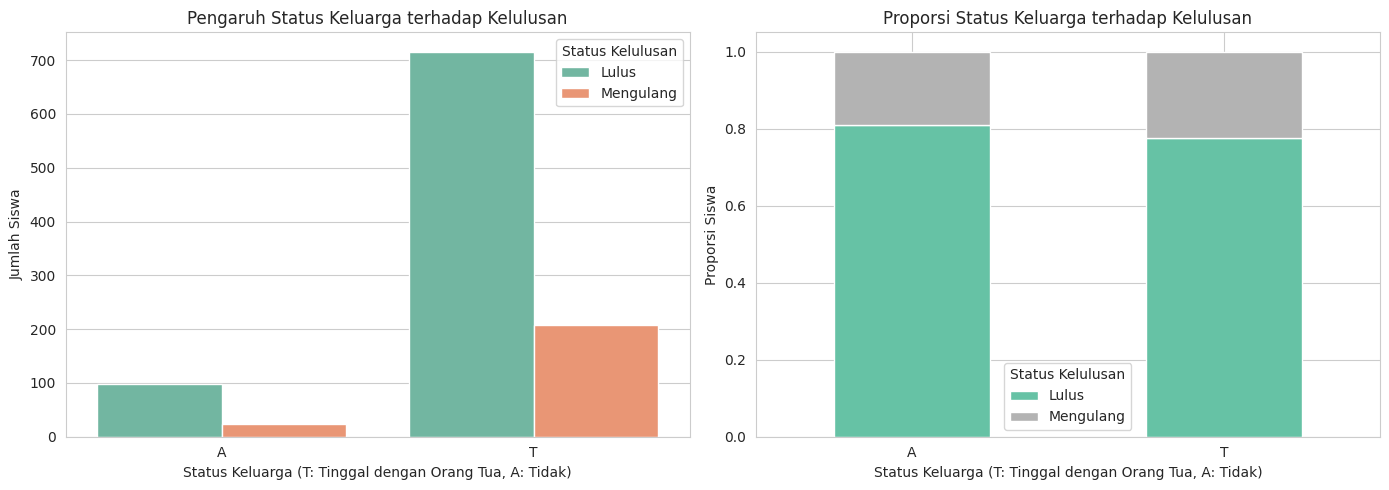

In [88]:
# Membuat figure dengan dua subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot jumlah siswa berdasarkan status keluarga dan kelulusan
sns.countplot(x="Pstatus", hue="Pass", data=df, palette="Set2", ax=axes[0])
axes[0].set_title("Pengaruh Status Keluarga terhadap Kelulusan")
axes[0].set_xlabel("Status Keluarga (T: Tinggal dengan Orang Tua, A: Tidak)")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Normalized barplot (proporsi siswa)
df_pstatus = df.groupby("Pstatus")["Pass"].value_counts(normalize=True).unstack()
df_pstatus.plot(kind="bar", stacked=True, colormap="Set2", ax=axes[1])
axes[1].set_title("Proporsi Status Keluarga terhadap Kelulusan")
axes[1].set_xlabel("Status Keluarga (T: Tinggal dengan Orang Tua, A: Tidak)")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_pstatus.index, rotation=0)

plt.tight_layout()
plt.show()


- Siswa yang tinggal bersama keluarga memiliki tinggkat kelulusan lebih tinggi dibanding tidak tinggal bersama keluarga

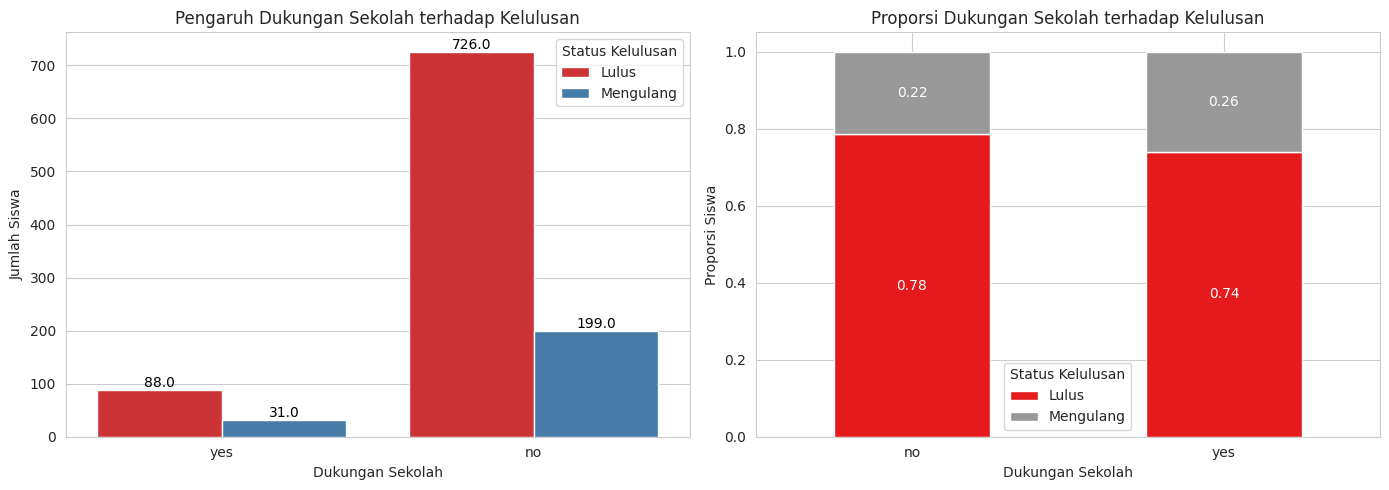

In [89]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jumlah siswa berdasarkan dukungan sekolah dan kelulusan
ax1 = sns.countplot(x="schoolsup", hue="Pass", data=df, palette="Set1", ax=axes[0])
axes[0].set_title("Pengaruh Dukungan Sekolah terhadap Kelulusan")
axes[0].set_xlabel("Dukungan Sekolah")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Menambahkan persentase ke dalam setiap bar
total_counts = df["schoolsup"].value_counts()
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=10, color='black')

# Normalized barplot
df_schoolsup = df.groupby("schoolsup")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_schoolsup.plot(kind="bar", stacked=True, colormap="Set1", ax=axes[1])
axes[1].set_title("Proporsi Dukungan Sekolah terhadap Kelulusan")
axes[1].set_xlabel("Dukungan Sekolah")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_schoolsup.index, rotation=0)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="white")

plt.tight_layout()
plt.show()


- Waktu luang tidak terlalu berpengaruh signifikan, tapi siswa dengan waktu luang sedang (2-4) lebih banyak yang lulus dibandingkan siswa dengan waktu luang sangat rendah atau sangat tinggi.

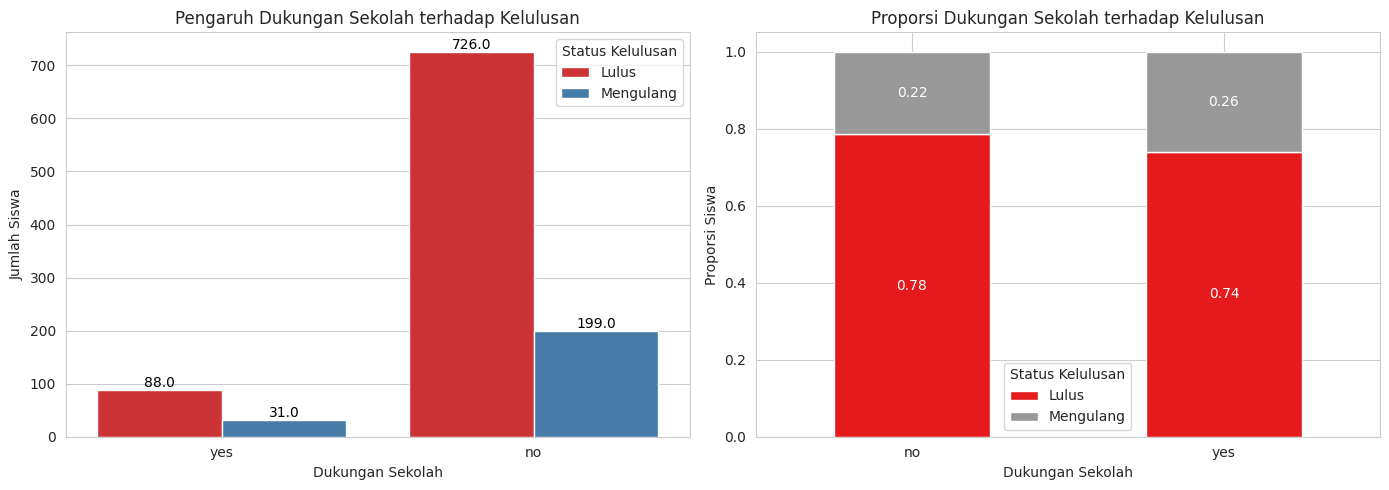

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jumlah siswa berdasarkan dukungan sekolah dan kelulusan
ax1 = sns.countplot(x="schoolsup", hue="Pass", data=df, palette="Set1", ax=axes[0])
axes[0].set_title("Pengaruh Dukungan Sekolah terhadap Kelulusan")
axes[0].set_xlabel("Dukungan Sekolah")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Menambahkan persentase ke dalam setiap bar
total_counts = df["schoolsup"].value_counts()
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=10, color='black')

# Normalized barplot
df_schoolsup = df.groupby("schoolsup")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_schoolsup.plot(kind="bar", stacked=True, colormap="Set1", ax=axes[1])
axes[1].set_title("Proporsi Dukungan Sekolah terhadap Kelulusan")
axes[1].set_xlabel("Dukungan Sekolah")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_schoolsup.index, rotation=0)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="white")

plt.tight_layout()
plt.show()


- Siswa yang mendapat dukungan tambahan dari sekolah lebih banyak yang mengulang. Ini bisa jadi karena mereka memang membutuhkan bantuan tambahan akibat kesulitan akademik.

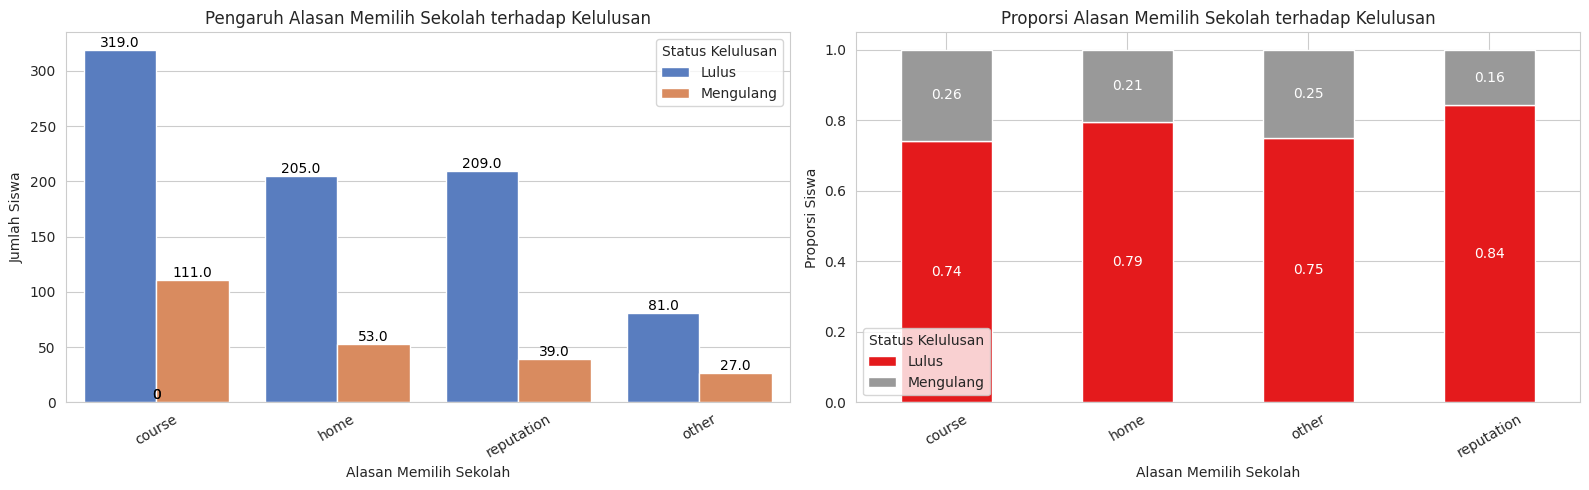

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot jumlah siswa berdasarkan alasan memilih sekolah dan kelulusan
ax1 = sns.countplot(x="reason", hue="Pass", data=df, palette="muted",
                    order=df["reason"].value_counts().index, ax=axes[0])
axes[0].set_title("Pengaruh Alasan Memilih Sekolah terhadap Kelulusan")
axes[0].set_xlabel("Alasan Memilih Sekolah")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)

# Menambahkan angka dalam bar
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Plot proporsi siswa (normalized barplot)
df_reason = df.groupby("reason")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_reason.plot(kind="bar", stacked=True, colormap="Set1", ax=axes[1])
axes[1].set_title("Proporsi Alasan Memilih Sekolah terhadap Kelulusan")
axes[1].set_xlabel("Alasan Memilih Sekolah")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_reason.index, rotation=30)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="white")

plt.tight_layout()
plt.show()

- Alasan terbanyak siswa bersekolah adalah karena reputasi pendidikan (reputation), diikuti oleh jarak ke sekolah (home).

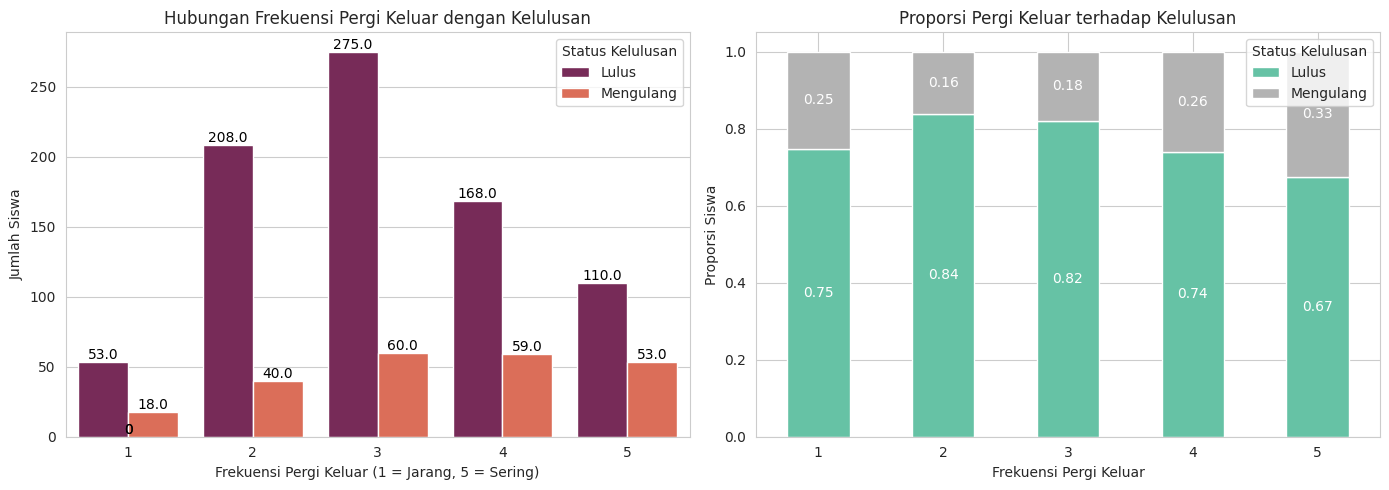

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot jumlah siswa
ax1 = sns.countplot(x="goout", hue="Pass", data=df, palette="rocket", ax=axes[0])
axes[0].set_title("Hubungan Frekuensi Pergi Keluar dengan Kelulusan")
axes[0].set_xlabel("Frekuensi Pergi Keluar (1 = Jarang, 5 = Sering)")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan")

# Menambahkan angka dalam bar
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Plot proporsi siswa
df_goout = df.groupby("goout")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_goout.plot(kind="bar", stacked=True, colormap="Set2", ax=axes[1])
axes[1].set_title("Proporsi Pergi Keluar terhadap Kelulusan")
axes[1].set_xlabel("Frekuensi Pergi Keluar")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan")
axes[1].set_xticklabels(df_goout.index, rotation=0)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="white")

plt.tight_layout()
plt.show()


- Siswa yang sering keluar malam (goout tinggi) cenderung lebih banyak yang mengulang daripada yang lebih sering di rumah.

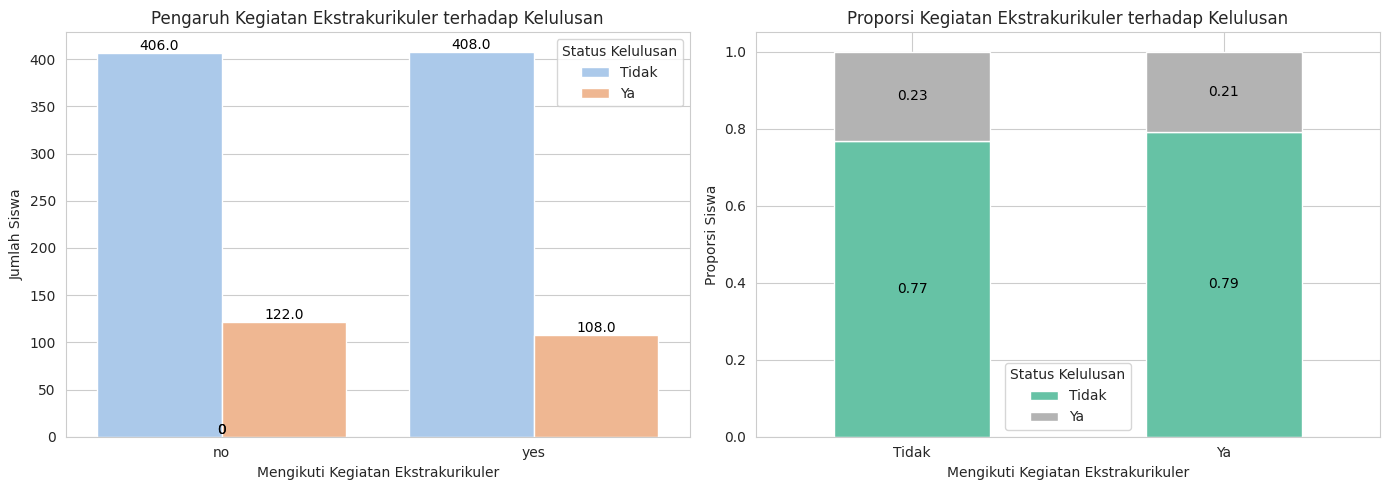

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot jumlah siswa berdasarkan ekstrakurikuler
ax1 = sns.countplot(x="activities", hue="Pass", data=df, palette="pastel", ax=axes[0])
axes[0].set_title("Pengaruh Kegiatan Ekstrakurikuler terhadap Kelulusan")
axes[0].set_xlabel("Mengikuti Kegiatan Ekstrakurikuler")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan", labels=["Tidak", "Ya"])

# Menambahkan angka dalam bar
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Plot proporsi siswa
df_activities = df.groupby("activities")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_activities.plot(kind="bar", stacked=True, colormap="Set2", ax=axes[1])
axes[1].set_title("Proporsi Kegiatan Ekstrakurikuler terhadap Kelulusan")
axes[1].set_xlabel("Mengikuti Kegiatan Ekstrakurikuler")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan", labels=["Tidak", "Ya"])
axes[1].set_xticklabels(["Tidak", "Ya"], rotation=0)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()


- Siswa yang mengikuti ekstrakurikuler cenderung sedikit lebih tinggi dibanding siswa yang tidak ikut

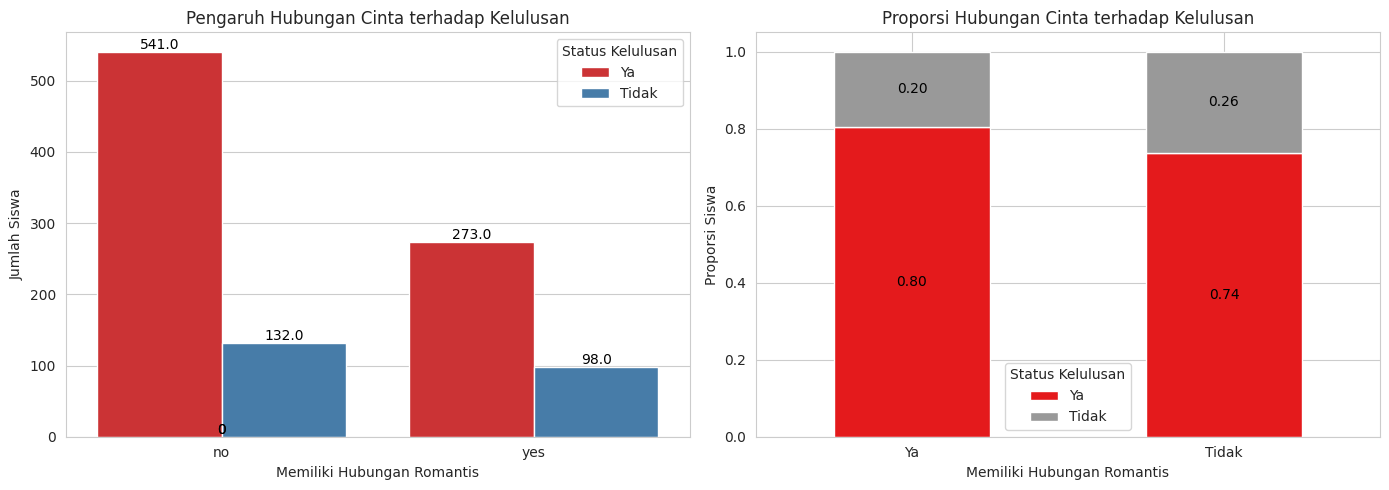

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot jumlah siswa berdasarkan hubungan romantis
ax1 = sns.countplot(x="romantic", hue="Pass", data=df, palette="Set1", ax=axes[0])
axes[0].set_title("Pengaruh Hubungan Cinta terhadap Kelulusan")
axes[0].set_xlabel("Memiliki Hubungan Romantis")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Status Kelulusan", labels=["Ya", "Tidak"])

# Menambahkan angka dalam bar
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Plot proporsi siswa
df_romantic = df.groupby("romantic")["Pass"].value_counts(normalize=True).unstack()
ax2 = df_romantic.plot(kind="bar", stacked=True, colormap="Set1", ax=axes[1])
axes[1].set_title("Proporsi Hubungan Cinta terhadap Kelulusan")
axes[1].set_xlabel("Memiliki Hubungan Romantis")
axes[1].set_ylabel("Proporsi Siswa")
axes[1].legend(title="Status Kelulusan", labels=["Ya", "Tidak"])
axes[1].set_xticklabels(["Ya", "Tidak"], rotation=0)

# Menambahkan persentase dalam setiap bar
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()


- Siswa yang tidak memiliki hubungan romantis memiliki tingkat persentase kelulusan lebih tinggi dibanding memiliki hubungan romantis

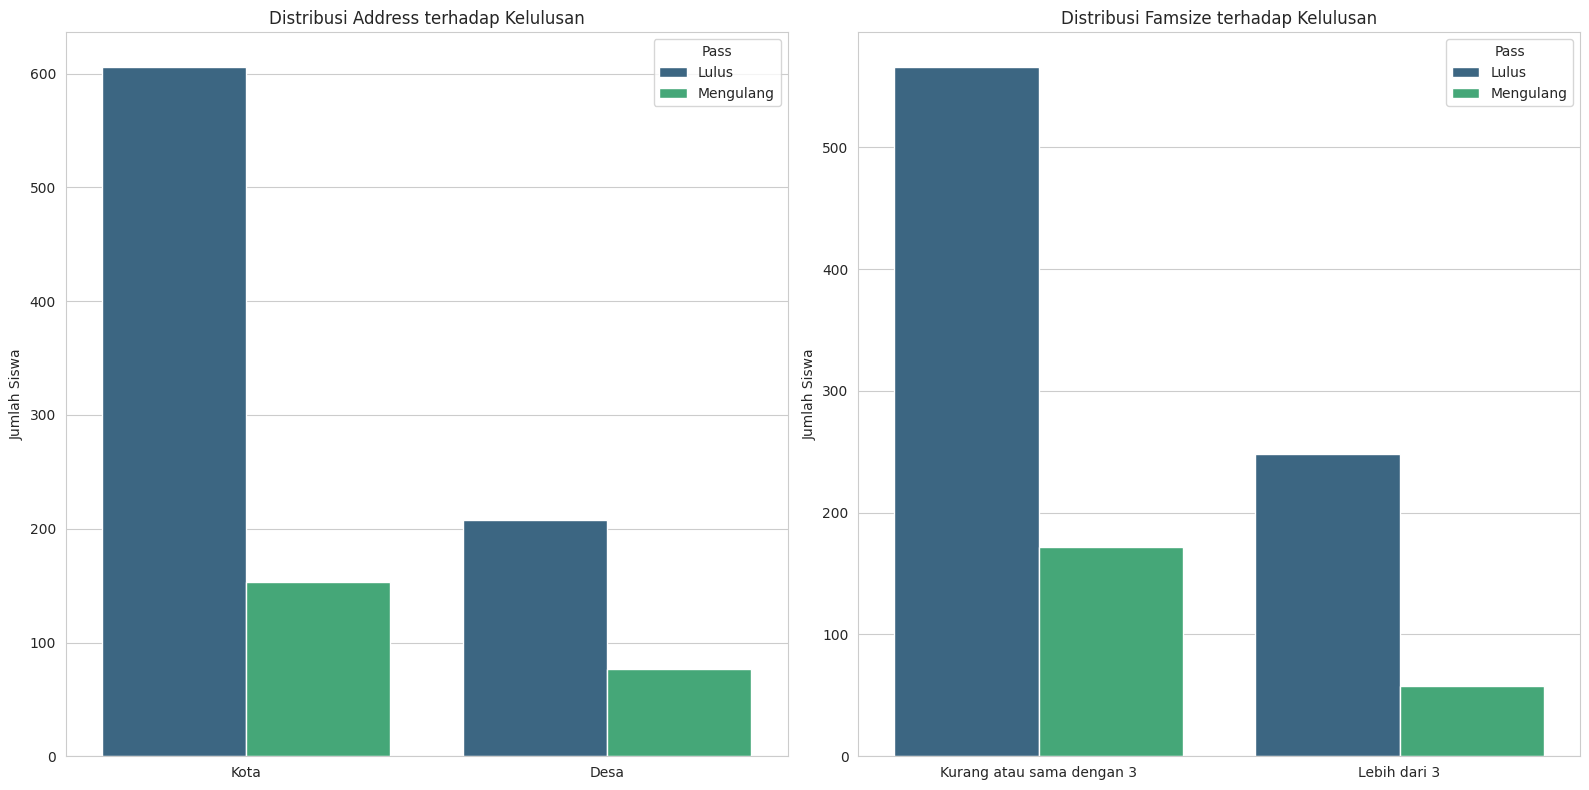

In [95]:
sns.set_style("whitegrid")

# Buat subplot dengan 2 kolom
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot pertama: Address vs Pass
sns.countplot(x="address", hue="Pass", data=df, ax=axes[0], palette="viridis")
axes[0].set_title("Distribusi Address terhadap Kelulusan")
axes[0].set_xlabel("")
axes[0].set_ylabel("Jumlah Siswa")
axes[0].legend(title="Pass")
axes[0].set_xticklabels(["Kota", "Desa"])

# Plot kedua: Famsize vs Pass
sns.countplot(x="famsize", hue="Pass", data=df, ax=axes[1], palette="viridis")
axes[1].set_title("Distribusi Famsize terhadap Kelulusan")
axes[1].set_xlabel("")
axes[1].set_ylabel("Jumlah Siswa")
axes[1].legend(title="Pass")
axes[1].set_xticklabels(["Kurang atau sama dengan 3", "Lebih dari 3"])

plt.tight_layout()
plt.show()

**Kesimpulan**

*   Jenis Kelamin (Gender): Tidak ada perbedaan signifikan antara laki-laki dan
perempuan dalam kelulusan.

* Lokasi Tempat Tinggal (address): Siswa yang tinggal di daerah Perkotaan (U) lebih banyak yang lulus dibandingkan siswa di daerah Desa (R).
*Ukuran Keluarga (famsize): Tidak ada perbedaan mencolok antara keluarga kecil (LE3) dan besar (GT3).
* Status Orang Tua (Pstatus): Siswa dengan orang tua yang tinggal bersama (T) lebih banyak yang lulus dibandingkan yang terpisah (A).
* Dukungan Sekolah (schoolsup): Siswa yang mendapat dukungan tambahan dari sekolah lebih banyak yang mengulang. Ini bisa jadi karena mereka memang membutuhkan bantuan tambahan akibat kesulitan akademik.
* Dukungan Keluarga (famsup): Dukungan keluarga tampaknya tidak berdampak signifikan terhadap kelulusan.
* Akses Internet (internet): Siswa yang memiliki akses internet di rumah lebih banyak yang lulus dibandingkan yang tidak.
* Hubungan Romantis (romantic): Siswa yang memiliki hubungan romantis cenderung lebih banyak yang mengulang dibandingkan yang tidak.

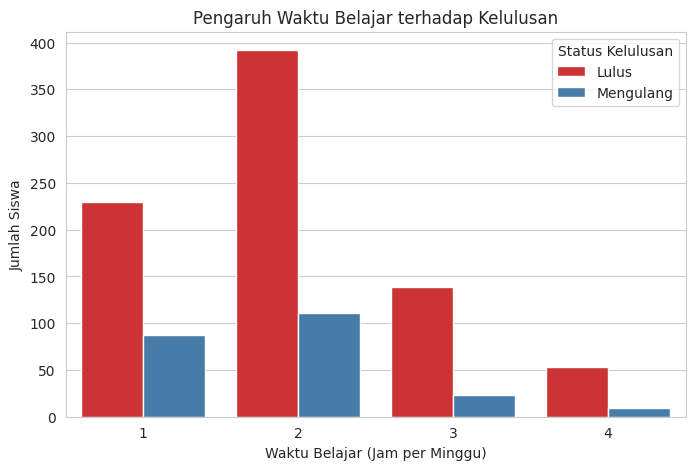

In [96]:
# Visualisasi hubungan waktu belajar dengan kelulusan
plt.figure(figsize=(8, 5))
sns.countplot(x="studytime", hue="Pass", data=df, palette="Set1")
plt.title("Pengaruh Waktu Belajar terhadap Kelulusan")
plt.xlabel("Waktu Belajar (Jam per Minggu)")
plt.ylabel("Jumlah Siswa")
plt.legend(title="Status Kelulusan")
plt.show()

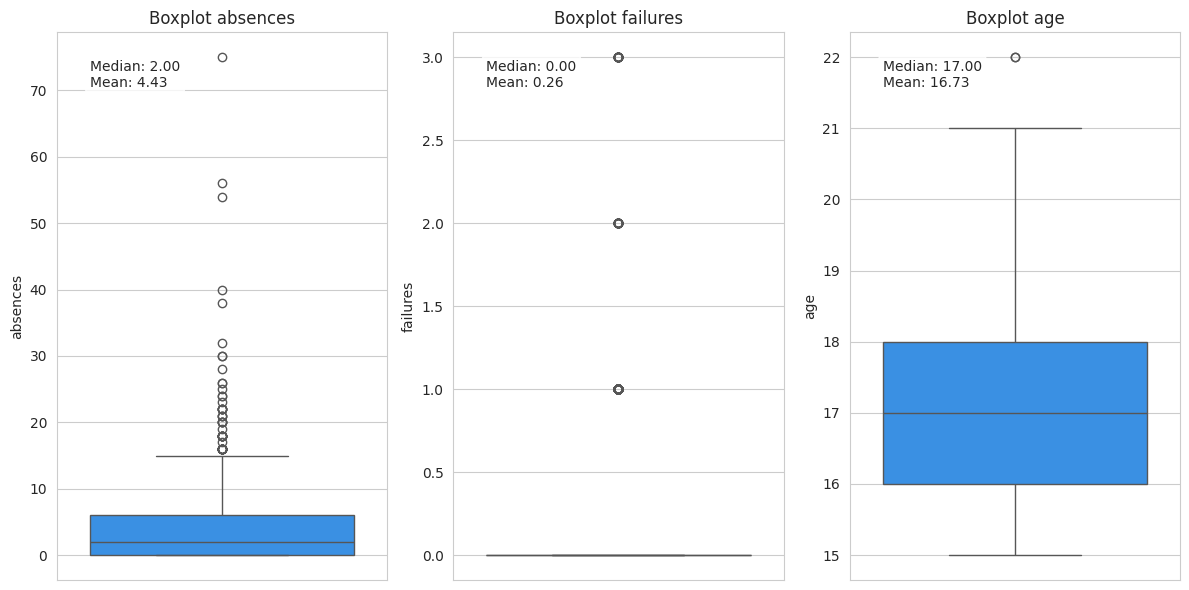

In [97]:
custom_color = "#1E90FF"  # Biru sedang

# Fitur numerik yang berpotensi bermasalah
outlier_features = ["absences", "failures", "age"]

# Buat figure dan subplot
plt.figure(figsize=(12, 6))
for i, feature in enumerate(outlier_features, 1):
    plt.subplot(1, 3, i)
    ax = sns.boxplot(y=df[feature], color=custom_color)  # Gunakan warna kustom
    plt.title(f"Boxplot {feature}", fontsize=12)
    plt.ylabel(feature, fontsize=10)

    # Tambahkan informasi median dan mean
    median = np.median(df[feature])
    mean = np.mean(df[feature])
    ax.text(0.1, 0.95, f"Median: {median:.2f}\nMean: {mean:.2f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

* Absences (Jumlah Absen) ->
Median: 2, artinya sebagian besar siswa hanya memiliki 2 kali absen,
Mean (Rata-rata): 4.43, menunjukkan ada beberapa siswa dengan absen sangat tinggi sehingga membuat rata-rata lebih besar dari median,
Outlier: Terlihat banyak siswa dengan jumlah absen di atas 20 kali, yang kemungkinan besar berpengaruh negatif terhadap kelulusan.

* Failures (Jumlah Kegagalan) -> Median: 2, artinya sebagian besar siswa hanya memiliki 2 kali absen, Mean (Rata-rata): 4.43, menunjukkan ada beberapa siswa dengan absen sangat tinggi sehingga membuat rata-rata lebih besar dari median,
Outlier: Terlihat banyak siswa dengan jumlah absen di atas 20 kali, yang kemungkinan besar berpengaruh negatif terhadap kelulusan.

* Age (Usia) -> Median: 17 tahun, yang menunjukkan mayoritas siswa berusia 17 tahun, Mean: 16.73, artinya ada sebagian siswa yang lebih muda dari 17 tahun,
Outlier: Siswa berusia 22 tahun kemungkinan adalah siswa yang pernah mengulang.


In [98]:
new_df = df.copy()

# Label encoding pada new_df saja
le = LabelEncoder()
new_df["Target"] = le.fit_transform(new_df["Pass"])

# Menyimpan encoder jika ingin digunakan kembali
label_encoders = {"Pass": le}

print(new_df.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \


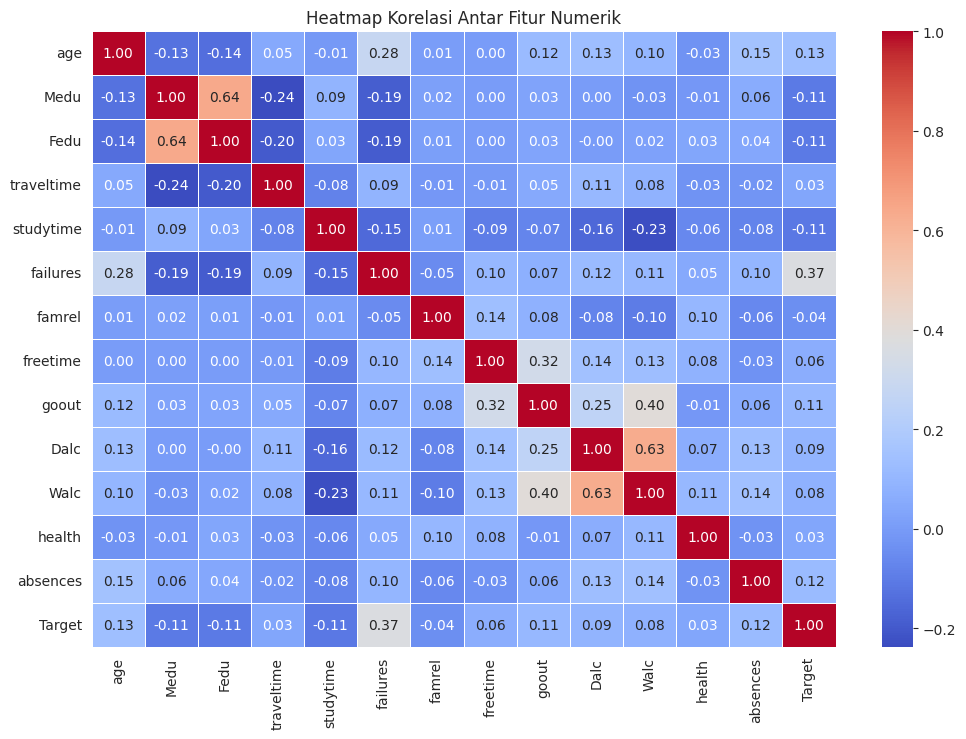

In [99]:
# Memilih hanya kolom numerik untuk heatmap
numeric_df = new_df.select_dtypes(include=["int64", "float64"])

# Membuat heatmap korelasi ulang
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.show()



* (Medu, Fedu) → 0.64 : Pendidikan ibu (Medu) dan ayah (Fedu) memiliki hubungan yang cukup kuat, karena tingkat pendidikan orang tua sering kali sebanding.

* (Dalc, Walc) → 0.63 : Konsumsi alkohol harian (Dalc) dan akhir pekan (Walc) sangat berkorelasi, yang menunjukkan bahwa siswa yang sering minum alkohol di hari biasa juga cenderung minum di akhir pekan.

* (Failures, Target) → 0.37 :
Jumlah kegagalan akademik memiliki korelasi sedang dengan Target (kemungkinan lulus/tidak lulus).
* (Goout, Walc) → 0.40 :
Siswa yang sering keluar bersama teman juga memiliki kebiasaan konsumsi alkohol yang lebih tinggi.
* (Goout, Dalc) → 0.25 :
Kebiasaan keluar bersama teman berkorelasi dengan konsumsi alkohol harian.
* (Freetime, Goout) → 0.32 :
Siswa dengan lebih banyak waktu luang cenderung lebih sering keluar.
* (Age, Failures) → 0.28 :
Semakin tua seorang siswa, kemungkinan jumlah kegagalannya juga meningkat.
* (Absences, Age) → 0.15 :
Usia sedikit berkorelasi dengan jumlah ketidakhadiran.
* (Health, Walc) → 0.11 :
Kesehatan siswa memiliki sedikit korelasi dengan kebiasaan konsumsi alkohol akhir pekan.
* (Studytime, Failures) → -0.15 :
Waktu belajar yang lebih tinggi sedikit berkorelasi negatif dengan jumlah kegagalan.



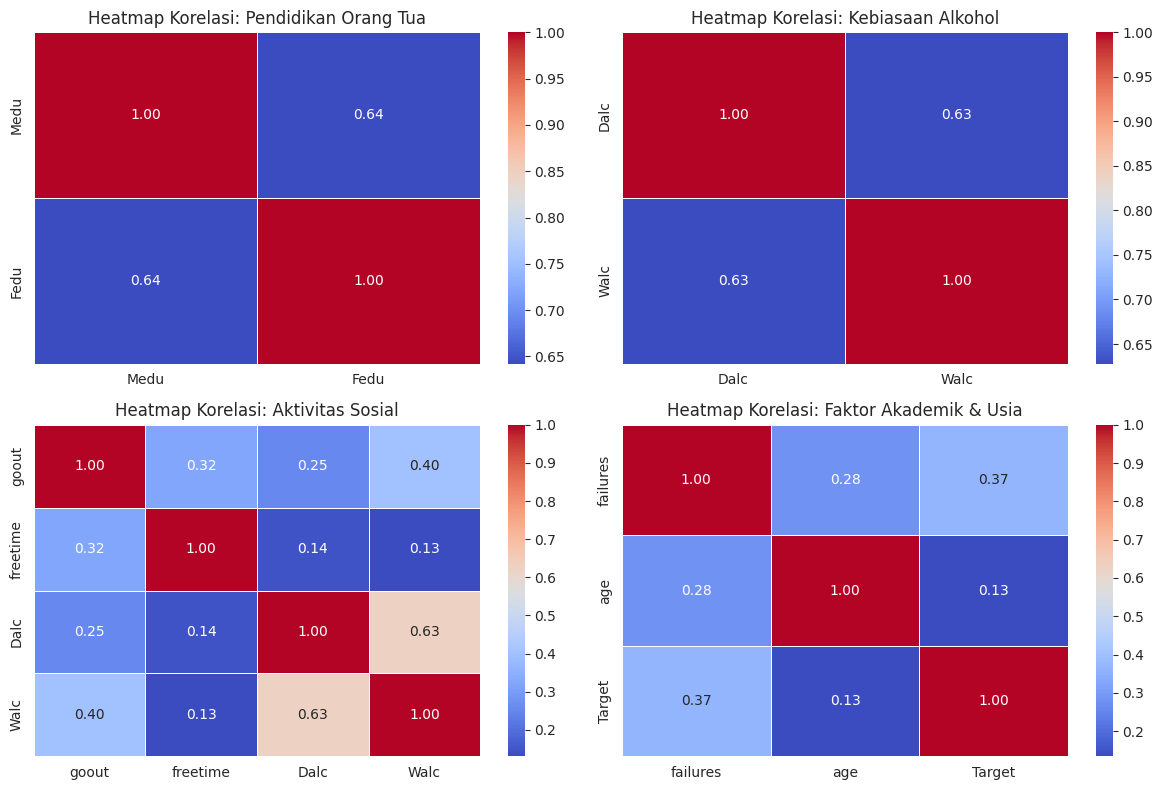

In [100]:
# Kelompok fitur berdasarkan korelasi tinggi yang sudah diidentifikasi
feature_groups = {
    "Pendidikan Orang Tua": ["Medu", "Fedu"],
    "Kebiasaan Alkohol": ["Dalc", "Walc"],
    "Aktivitas Sosial": ["goout", "freetime", "Dalc", "Walc"],
    "Faktor Akademik & Usia": ["failures", "age", "Target"]
}

# Ukuran figur untuk visualisasi
plt.figure(figsize=(12, 8))

# Membuat heatmap untuk setiap kelompok fitur
for i, (group_name, features) in enumerate(feature_groups.items()):
    plt.subplot(2, 2, i + 1)
    corr_matrix = new_df[features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(f"Heatmap Korelasi: {group_name}")

plt.tight_layout()
plt.show()


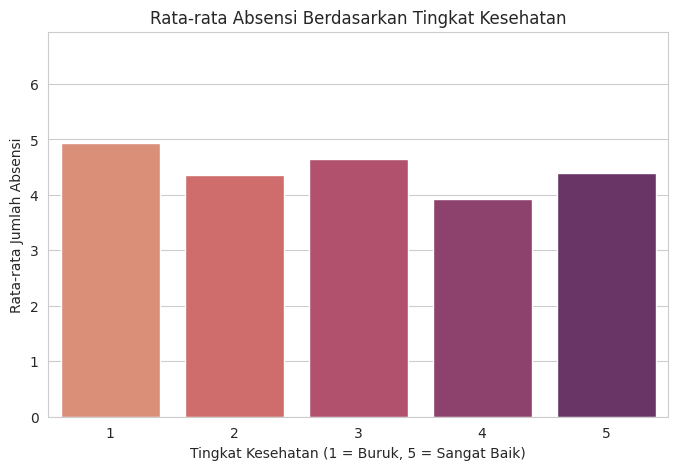

In [101]:
# Menghitung rata-rata absensi untuk setiap tingkat kesehatan
health_absence_avg = df.groupby("health")["absences"].mean()

# Membuat bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=health_absence_avg.index, y=health_absence_avg.values, palette="flare")

# Label dan judul
plt.xlabel("Tingkat Kesehatan (1 = Buruk, 5 = Sangat Baik)")
plt.ylabel("Rata-rata Jumlah Absensi")
plt.title("Rata-rata Absensi Berdasarkan Tingkat Kesehatan")
plt.ylim(0, max(health_absence_avg.values) + 2)

plt.show()


* rata-rata absensi meningkat pada siswa dengan kesehatan lebih buruk, ini bisa menunjukkan bahwa siswa yang sering sakit cenderung lebih sering absen.

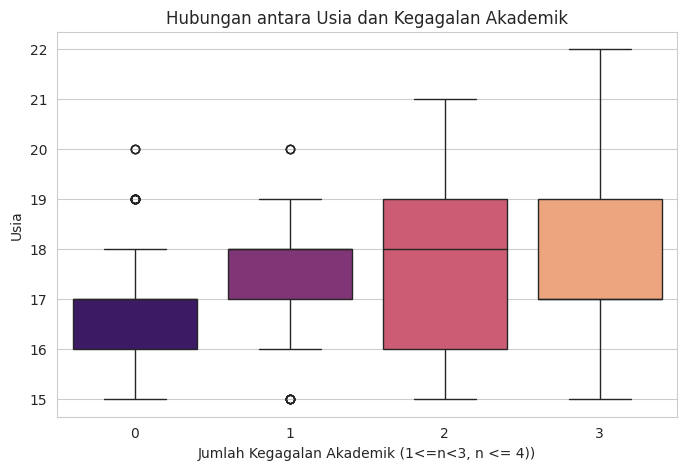

In [102]:
# Visualisasi hubungan antara Usia dan Kegagalan Akademik
plt.figure(figsize=(8, 5))
sns.boxplot(x="failures", y="age", data=df, palette="magma")
plt.title("Hubungan antara Usia dan Kegagalan Akademik")
plt.xlabel("Jumlah Kegagalan Akademik (1<=n<3, n <= 4))")
plt.ylabel("Usia")
plt.show()

* Semakin tua seorang siswa, kemungkinan jumlah kegagalannya juga meningkat.

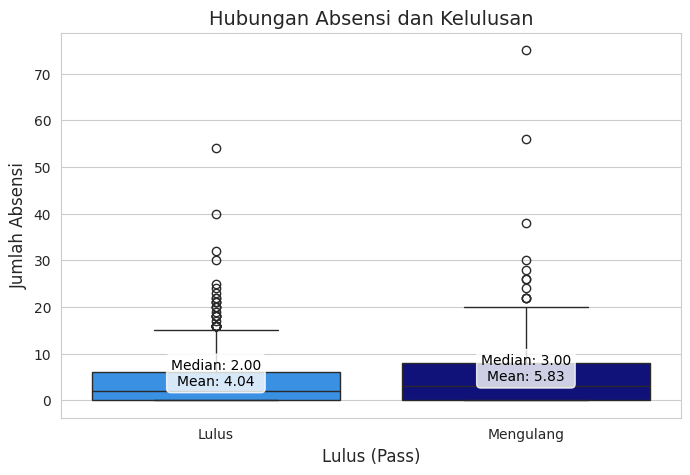

In [103]:
# Warna kustom untuk boxplot
custom_palette = ["#1E90FF", "#00008B"]  # Biru sedang dan biru gelap

# Visualisasi hubungan Absensi vs Kelulusan
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x=df["Pass"], y=df["absences"], palette=custom_palette)  # Gunakan palette kustom
plt.title("Hubungan Absensi dan Kelulusan", fontsize=14)
plt.xlabel("Lulus (Pass)", fontsize=12)
plt.ylabel("Jumlah Absensi", fontsize=12)

# Menambahkan informasi median dan mean
for i, category in enumerate(df["Pass"].unique()):
    data = df[df["Pass"] == category]["absences"]
    median = np.median(data)
    mean = np.mean(data)
    ax.text(i, median + 0.5, f"Median: {median:.2f}\nMean: {mean:.2f}",
            fontsize=10, color='black', ha='center', va='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

Berdasarkan visualisasi, siswa yang **mengulang** cenderung memiliki jumlah absensi yang lebih rendah secara median dibandingkan siswa yang **lulus**, namun terdapat banyak outlier dengan absensi sangat tinggi. Hal ini menunjukkan bahwa **absensi rendah tidak menjamin kelulusan**, karena kemungkinan ada faktor lain yang mempengaruhi seperti nilai akademik atau kegagalan sebelumnya. Sementara itu, siswa yang **lulus** memiliki jumlah absensi lebih terkontrol meskipun rata-rata absensi mereka sedikit lebih tinggi.

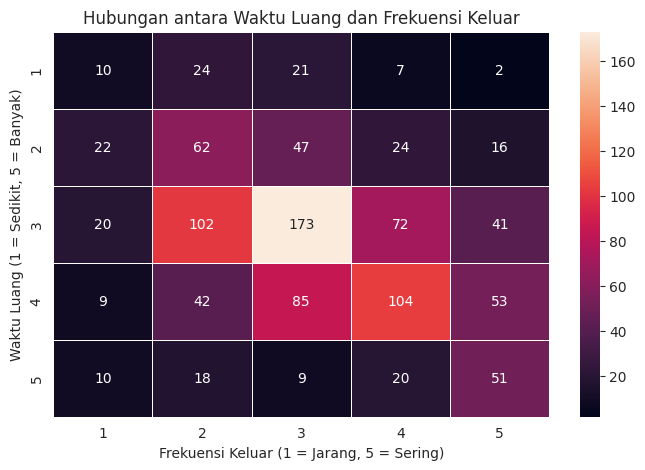

In [104]:
# Membuat pivot table untuk heatmap
table = df.pivot_table(index="freetime", columns="goout", aggfunc="size", fill_value=0)

plt.figure(figsize=(8, 5))
sns.heatmap(table, annot=True, cmap="rocket", fmt="d", linewidths=0.5)
plt.title("Hubungan antara Waktu Luang dan Frekuensi Keluar")
plt.xlabel("Frekuensi Keluar (1 = Jarang, 5 = Sering)")
plt.ylabel("Waktu Luang (1 = Sedikit, 5 = Banyak)")
plt.show()

* Siswa dengan lebih banyak waktu luang cenderung lebih sering keluar.

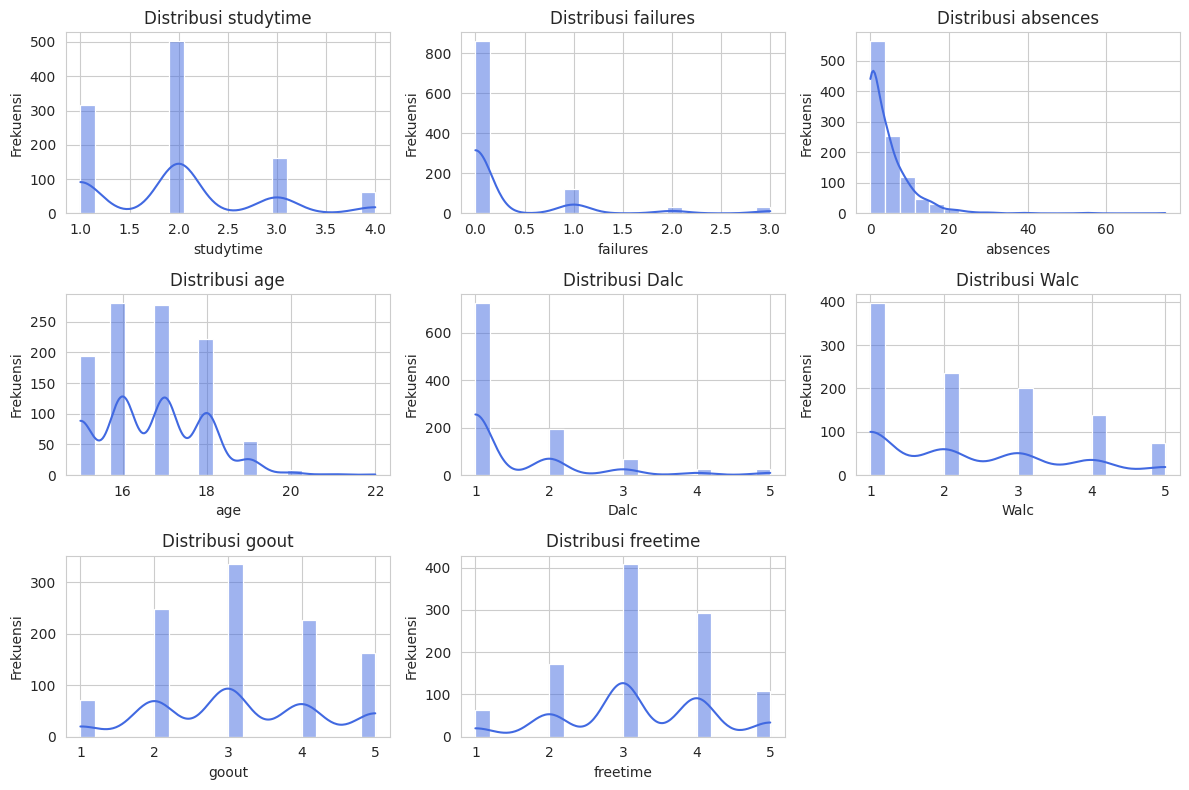

In [105]:
# Plot distribusi fitur numerik menggunakan histogram
numeric_features = ["studytime", "failures", "absences", "age", "Dalc", "Walc", "goout", "freetime"]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=20, color="royalblue")
    plt.title(f"Distribusi {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()


* Mayoritas siswa memiliki waktu belajar 2 jam per hari (503 siswa).
Semakin sedikit waktu belajar (1 jam), semakin banyak jumlah siswa, tapi kemungkinan kelulusannya lebih rendah dari yang belajar lebih lama.

* Sebagian besar siswa tidak pernah gagal (861 siswa).
Siswa dengan jumlah kegagalan 0 memiliki peluang lebih tinggi untuk lulus, sedangkan siswa dengan lebih banyak kegagalan (1-3) cenderung lebih sedikit.

* Mayoritas siswa memiliki jumlah absen antara 0-10 kali (564 siswa).
Semakin tinggi angka absen, semakin sedikit jumlah siswa, dan peluang untuk mengulang lebih besar.

* Usia terbanyak adalah 16 dan 17 tahun (masing-masing 281 dan 277 siswa).
Siswa yang lebih muda cenderung lebih banyak dibandingkan siswa di atas 18 tahun.

* Dalc (Konsumsi Alkohol Harian) ->
Mayoritas siswa memiliki konsumsi alkohol harian rendah (1 = 727 siswa).
Konsumsi alkohol tinggi (5) hanya sedikit, artinya kebanyakan siswa tidak sering konsumsi alkohol di hari biasa.

* Walc (Konsumsi Alkohol di Akhir Pekan) ->
Konsumsi alkohol di akhir pekan paling banyak pada level 1 dan 2 (398 & 235 siswa).
Siswa yang lebih sering minum di akhir pekan (4-5) jumlahnya lebih sedikit, tapi kemungkinan besar lebih berisiko mengulang.

* Goout (Sering Keluar Bareng Teman) ->
Siswa paling banyak keluar dengan teman pada level 3 (335 siswa).
Semakin sering keluar malam (5), jumlah siswa semakin menurun, yang menunjukkan lebih banyak siswa fokus pada studi daripada keluar malam.

* Freetime (Waktu Luang) ->
Mayoritas siswa memiliki waktu luang sedang (3 dan 4) dengan jumlah 408 dan 293 siswa.
Waktu luang yang seimbang kemungkinan besar berpengaruh pada tingkat kelulusan.



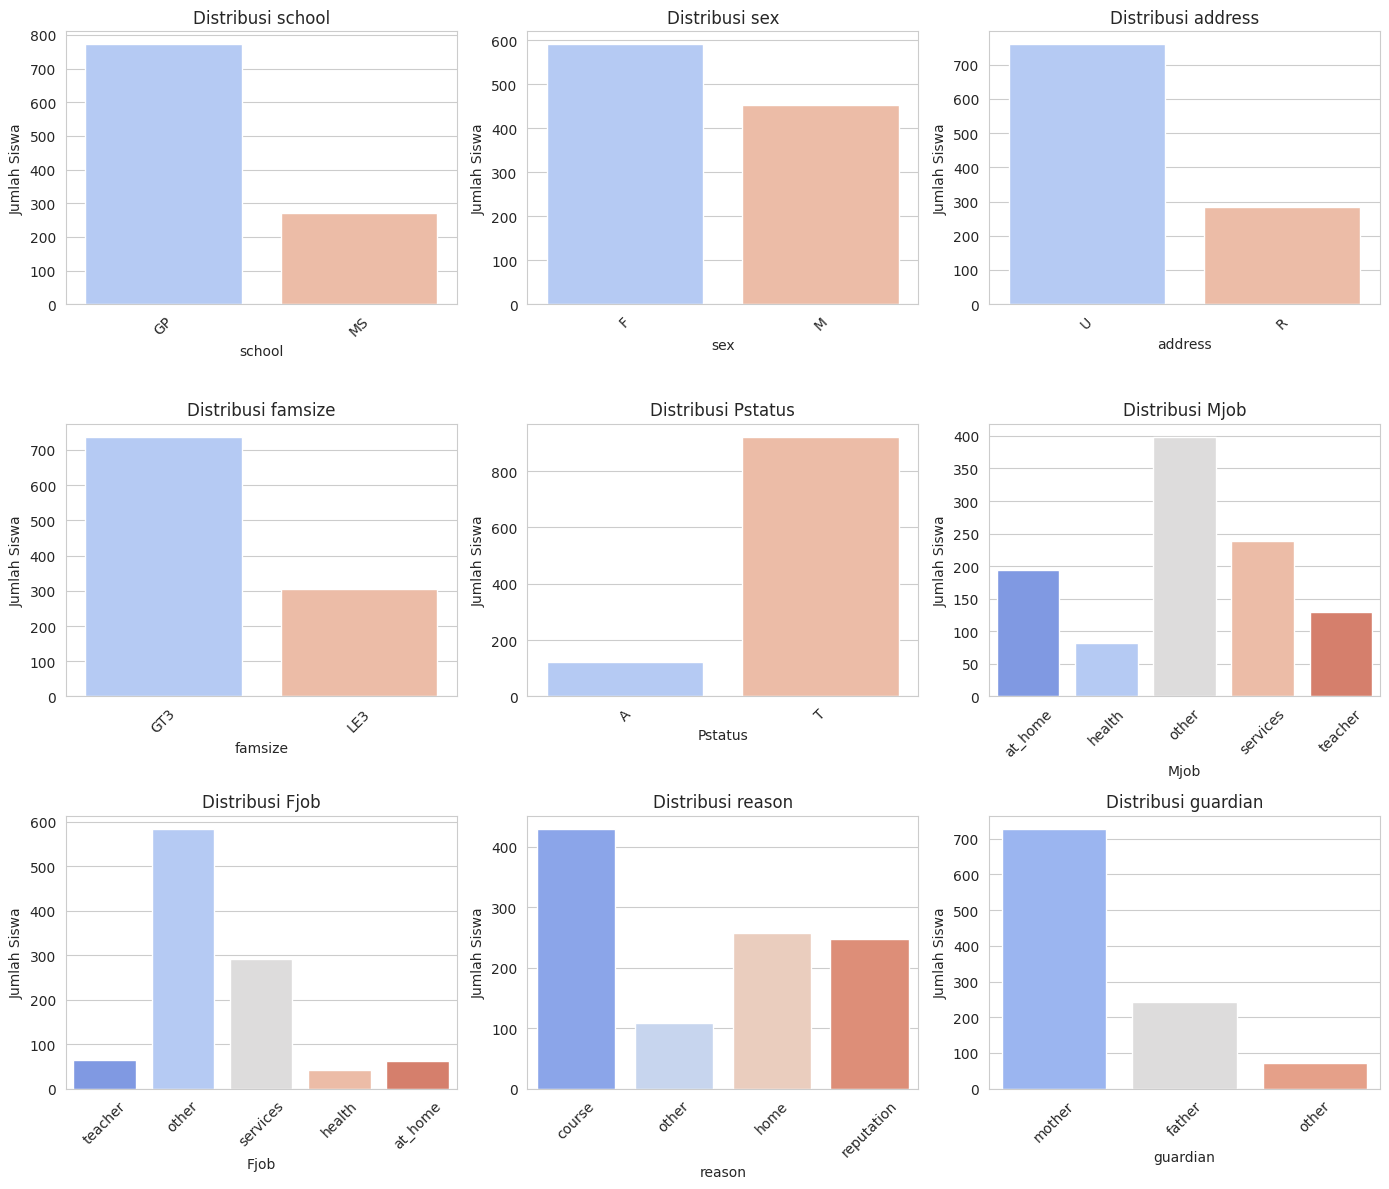

In [106]:
# Memilih fitur kategorikal untuk countplot
categorical_features = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian"]

plt.figure(figsize=(14, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[feature], palette="coolwarm")
    plt.title(f"Distribusi {feature}")
    plt.xlabel(feature)
    plt.ylabel("Jumlah Siswa")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


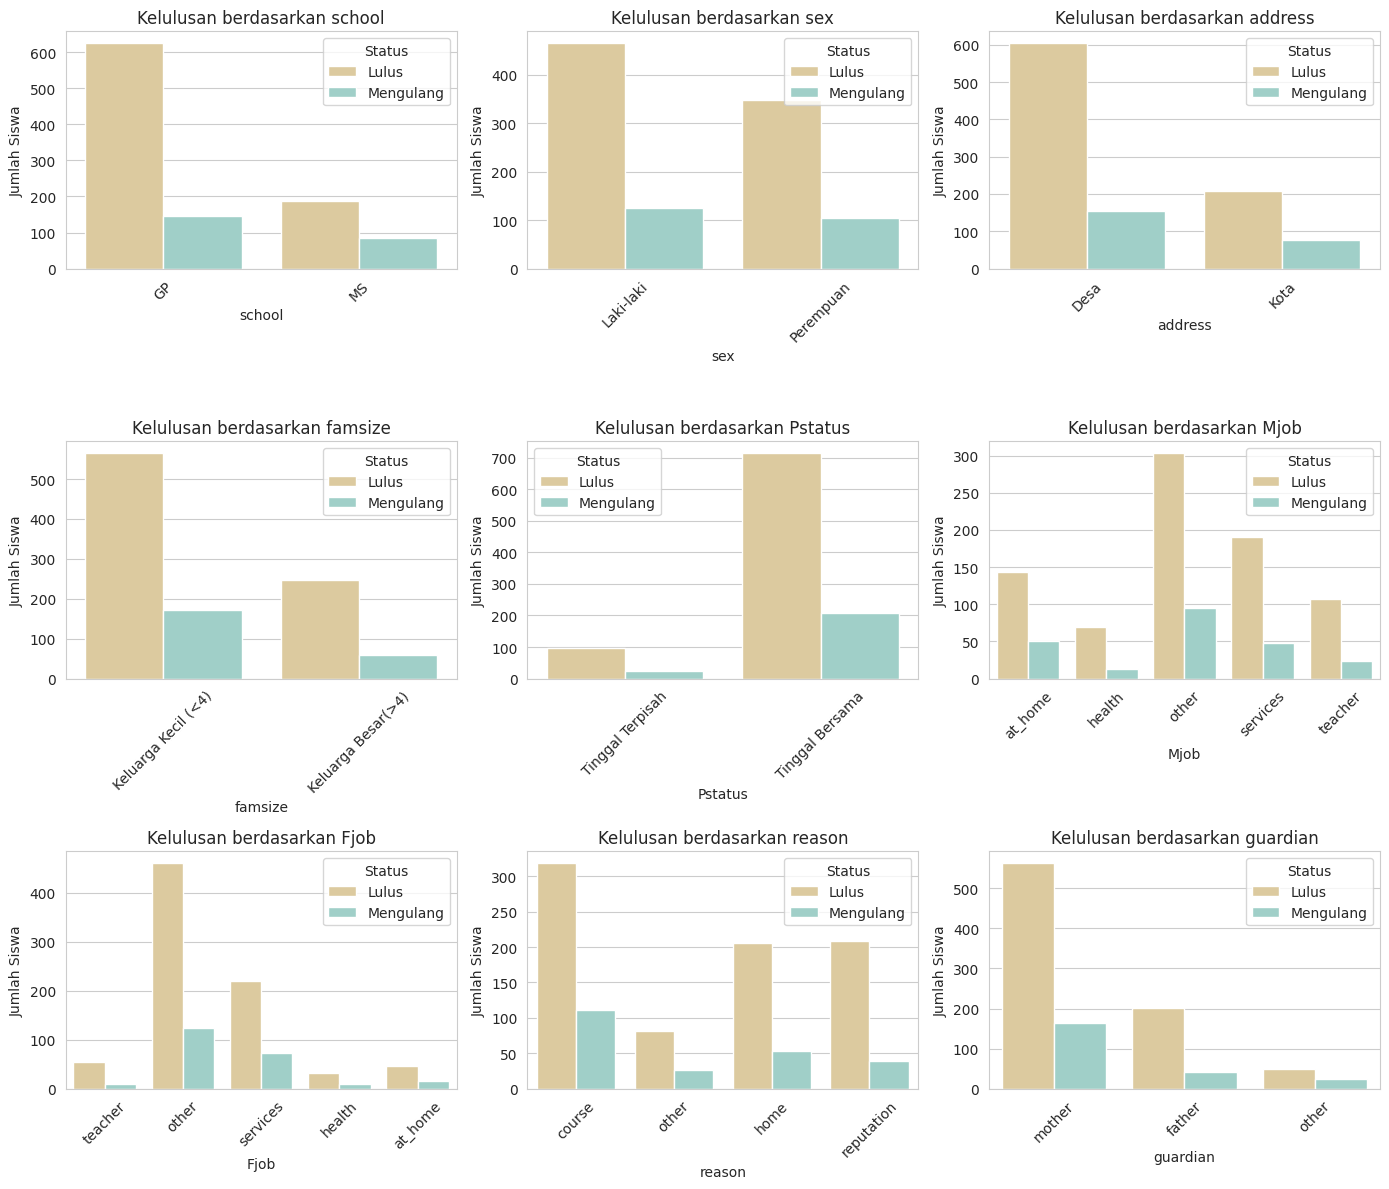

In [107]:
label_mappings = {
    "sex": ["Laki-laki", "Perempuan"],
    "address": ["Desa", "Kota"],
    "famsize": ["Keluarga Kecil (<4)", "Keluarga Besar(>4)"],
    "Pstatus": ["Tinggal Terpisah", "Tinggal Bersama"],
    "schoolsup": ["Tidak", "Ya"],
    "famsup": ["Tidak", "Ya"],
    "internet": ["Tidak", "Ya"],
    "romantic": ["Tidak", "Ya"]
}

# Membandingkan distribusi fitur kategorikal terhadap kelulusan
plt.figure(figsize=(14, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    ax = sns.countplot(x=df[feature], hue=df["Pass"], palette="BrBG")
    plt.title(f"Kelulusan berdasarkan {feature}")
    plt.xlabel(feature)
    plt.ylabel("Jumlah Siswa")
    plt.xticks(rotation=45)
    plt.legend(title="Status", labels=["Lulus", "Mengulang"])

    # Mengubah label pada sumbu x jika feature ada dalam dictionary
    if feature in label_mappings:
        ax.set_xticklabels(label_mappings[feature])

plt.tight_layout()
plt.show()

* Kelulusan berdasarkan Sekolah (school) ->
Siswa dari sekolah GP lebih banyak yang lulus dibandingkan sekolah MS. Namun, jumlah siswa mengulang di MS lebih proporsional dibanding GP.

* Kelulusan berdasarkan Jenis Kelamin (sex) ->
Perempuan (F) memiliki tingkat kelulusan lebih tinggi dibandingkan laki-laki (M), meskipun jumlah siswa perempuan lebih banyak.

* Kelulusan berdasarkan Alamat (address) ->
Siswa yang tinggal di daerah urban (U) lebih banyak yang lulus dibandingkan siswa dari daerah rural (R).

* Kelulusan berdasarkan Ukuran Keluarga (famsize) ->
Siswa dari keluarga besar (GT3) memiliki tingkat kelulusan lebih tinggi dibandingkan siswa dari keluarga kecil (LE3).

* Kelulusan berdasarkan Status Orang Tua (Pstatus) ->
Siswa dengan orang tua yang bersama (T) lebih banyak yang lulus dibandingkan siswa dengan orang tua yang berpisah (A).

* Kelulusan berdasarkan Pekerjaan Ibu (Mjob) ->
Ibu yang bekerja di bidang lain-lain (other) memiliki jumlah siswa lulus paling banyak, sedangkan siswa dengan ibu bekerja sebagai guru (teacher) cenderung memiliki tingkat kelulusan lebih rendah.

* Kelulusan berdasarkan Pekerjaan Ayah (Fjob) ->
Siswa dengan ayah bekerja di bidang lain-lain (other) memiliki tingkat kelulusan tertinggi, sementara pekerjaan sebagai guru (teacher) menunjukkan jumlah siswa mengulang lebih rendah dibanding pekerjaan lainnya.

* Kelulusan berdasarkan Alasan Sekolah (reason) ->
Alasan course (mata pelajaran) memiliki jumlah siswa lulus paling banyak, sedangkan alasan home (jarak rumah) cenderung memiliki lebih banyak siswa yang mengulang dibanding alasan lainnya.

* Kelulusan berdasarkan Wali (guardian) ->
Siswa yang memiliki wali ibu (mother) menunjukkan tingkat kelulusan tertinggi dibandingkan wali ayah (father) atau lainnya (other).

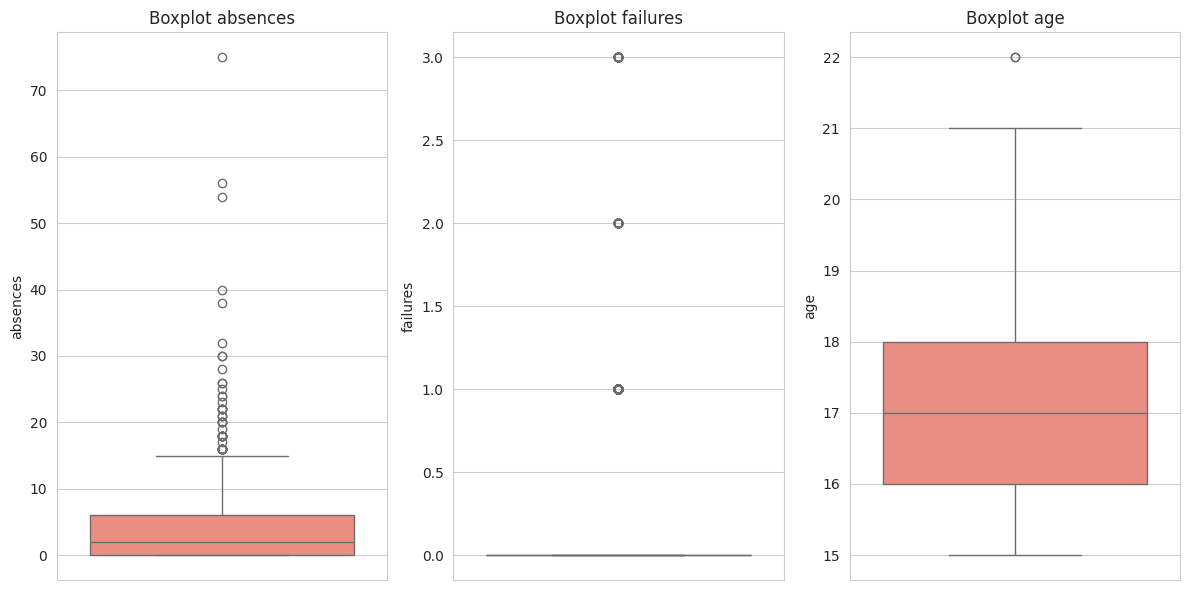

In [108]:
# Membuat boxplot untuk mendeteksi outlier pada fitur Absences
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=df["absences"], color="salmon")
plt.title("Boxplot absences")
plt.ylabel("absences")

# Boxplot untuk 'failures'
plt.subplot(1, 3, 2)
sns.boxplot(y=df["failures"], color="salmon")
plt.title("Boxplot failures")
plt.ylabel("failures")

# Boxplot untuk 'age'
plt.subplot(1, 3, 3)
sns.boxplot(y=df["age"], color="salmon")
plt.title("Boxplot age")
plt.ylabel("age")

plt.tight_layout()
plt.show()



* Absences (Jumlah Absen) ->
Median: 2, artinya sebagian besar siswa hanya memiliki 2 kali absen,
Mean (Rata-rata): 4.43, menunjukkan ada beberapa siswa dengan absen sangat tinggi sehingga membuat rata-rata lebih besar dari median,
Outlier: Terlihat banyak siswa dengan jumlah absen di atas 20 kali, yang kemungkinan besar berpengaruh negatif terhadap kelulusan.

* Failures (Jumlah Kegagalan) -> Median: 2, artinya sebagian besar siswa hanya memiliki 2 kali absen, Mean (Rata-rata): 4.43, menunjukkan ada beberapa siswa dengan absen sangat tinggi sehingga membuat rata-rata lebih besar dari median,
Outlier: Terlihat banyak siswa dengan jumlah absen di atas 20 kali, yang kemungkinan besar berpengaruh negatif terhadap kelulusan.

* Age (Usia) -> Median: 17 tahun, yang menunjukkan mayoritas siswa berusia 17 tahun, Mean: 16.73, artinya ada sebagian siswa yang lebih muda dari 17 tahun,
Outlier: Siswa berusia 22 tahun kemungkinan adalah siswa yang pernah mengulang.


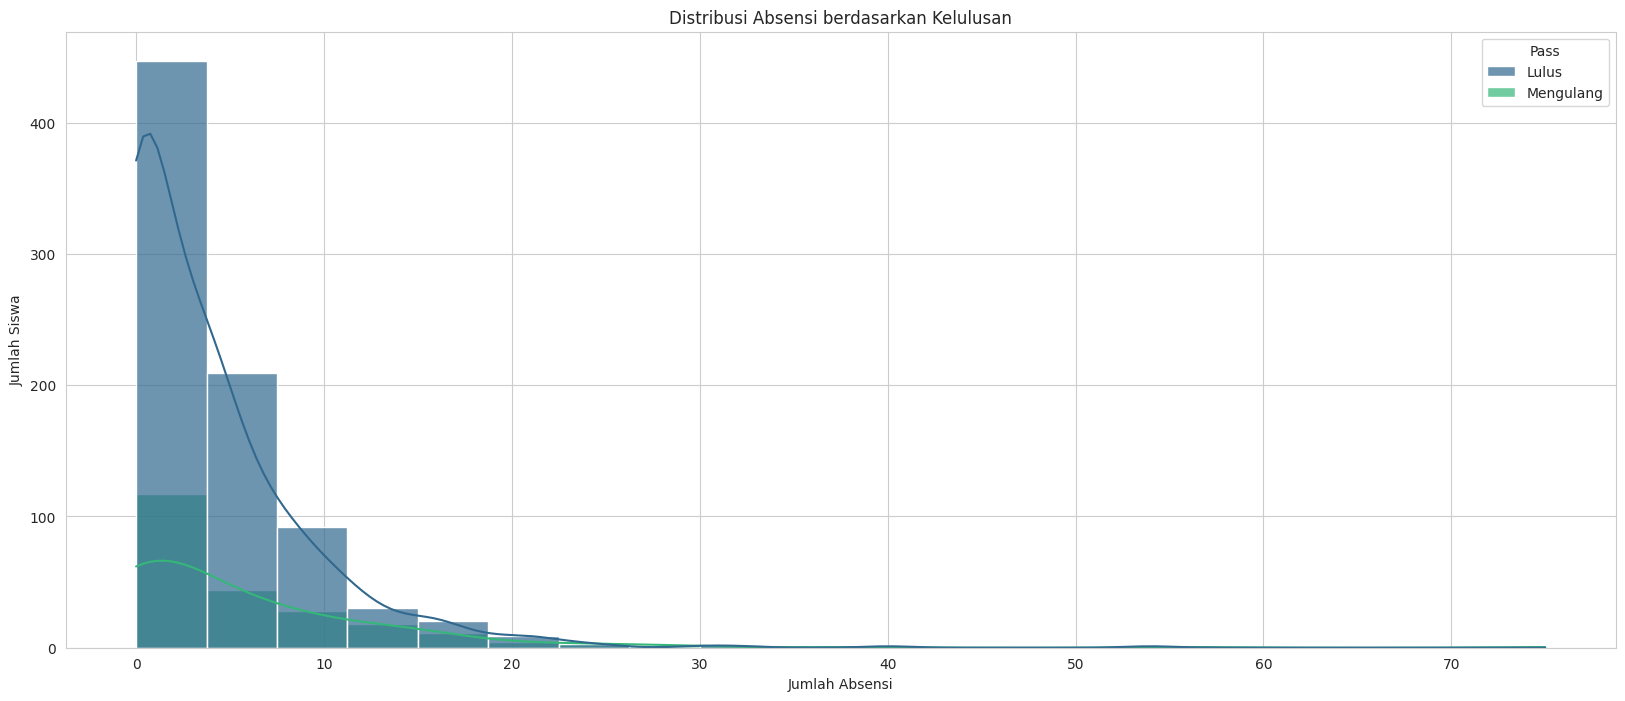

In [109]:
plt.figure(figsize=(20, 8))
sns.histplot(data=df, x="absences", hue="Pass", bins=20, kde=True, palette="viridis", alpha=0.7)
plt.title("Distribusi Absensi berdasarkan Kelulusan")
plt.xlabel("Jumlah Absensi")
plt.ylabel("Jumlah Siswa")

plt.show()

Grafik ini menunjukkan hubungan antara jumlah absensi (jumlah ketidakhadiran) dengan kelulusan siswa.
Siswa yang Lulus (warna biru tua) cenderung memiliki jumlah absensi yang lebih rendah dibandingkan siswa yang Mengulang (warna hijau muda).
Sebagian besar siswa yang Lulus memiliki jumlah absensi antara 0 hingga 10 kali, sedangkan siswa yang Mengulang memiliki sebaran absensi yang lebih tinggi, bahkan hingga lebih dari 30 kali.
Pola ini menunjukkan bahwa absensi yang tinggi berhubungan dengan tingkat kegagalan yang lebih tinggi, karena siswa yang sering absen lebih sulit memahami materi pelajaran.

## Data Preprocessing

### One Hot Encoding Data Kategorikal

In [110]:
df["Pass"] = df["Pass"].replace({"Lulus": 1, "Mengulang": 0})

# One-hot encoding untuk kolom kategori
df = pd.get_dummies(df, columns=[
    "address", "famsize", "schoolsup", "paid", "activities", "higher", "internet" ,
    "sex" ,"school", "Mjob", "Fjob", "reason", "guardian", "romantic", "famsup",
    "nursery", "Pstatus"], drop_first=True).astype(int)

In [111]:
pd.set_option('display.max_columns', None)
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Pass,address_U,famsize_LE3,schoolsup_yes,paid_yes,activities_yes,higher_yes,internet_yes,sex_M,school_MS,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,romantic_yes,famsup_yes,nursery_yes,Pstatus_T
0,18,4,4,2,2,0,4,3,4,1,1,3,4,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,15,1,1,1,2,0,4,3,2,2,3,3,6,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
3,15,4,2,1,3,0,3,2,2,1,1,5,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                1044 non-null   int64
 1   Medu               1044 non-null   int64
 2   Fedu               1044 non-null   int64
 3   traveltime         1044 non-null   int64
 4   studytime          1044 non-null   int64
 5   failures           1044 non-null   int64
 6   famrel             1044 non-null   int64
 7   freetime           1044 non-null   int64
 8   goout              1044 non-null   int64
 9   Dalc               1044 non-null   int64
 10  Walc               1044 non-null   int64
 11  health             1044 non-null   int64
 12  absences           1044 non-null   int64
 13  Pass               1044 non-null   int64
 14  address_U          1044 non-null   int64
 15  famsize_LE3        1044 non-null   int64
 16  schoolsup_yes      1044 non-null   int64
 17  paid_yes      

### Feature Importance Terhadap Target

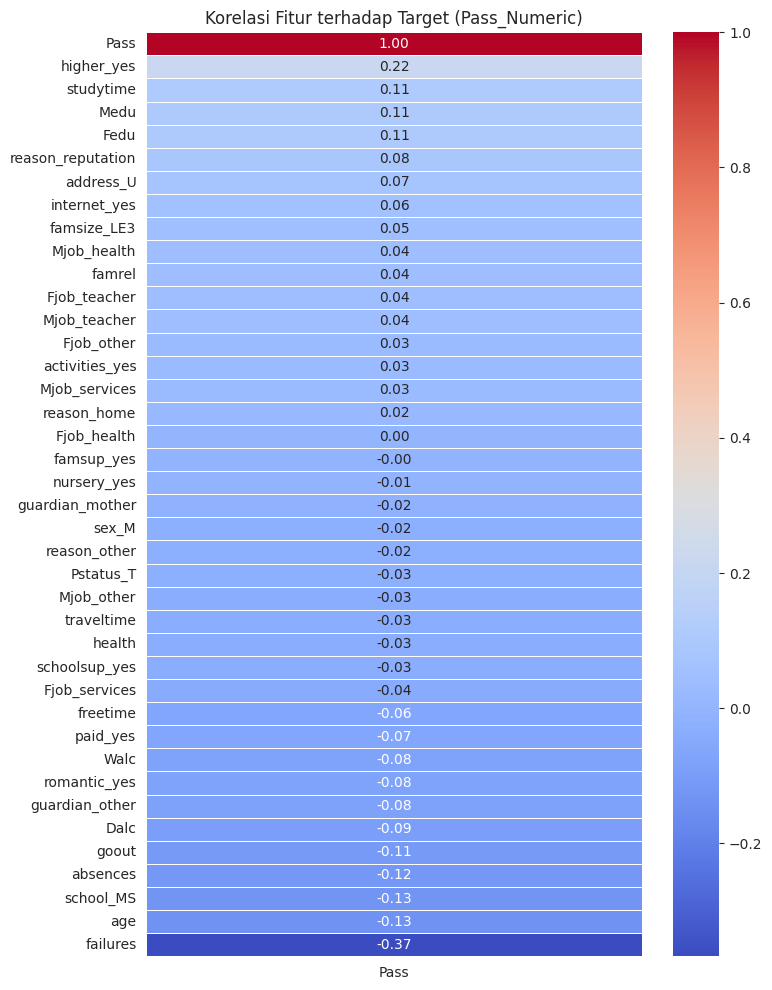

,Pass
Pass,1.000000
higher_yes,0.218430
studytime,0.108553
Medu,0.106460
Fedu,0.105579
reason_reputation,0.084912
address_U,0.073732
internet_yes,0.058058
famsize_LE3,0.047797
Mjob_health,0.043513


In [113]:
correlation_matrix = df.corr()
target_corr = correlation_matrix["Pass"].sort_values(ascending=False)

# Visualisasi korelasi dengan target
plt.figure(figsize=(8, 12))
sns.heatmap(target_corr.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Korelasi Fitur terhadap Target (Pass_Numeric)")
plt.show()

target_corr

### Deteksi Outlier Kolom Absences

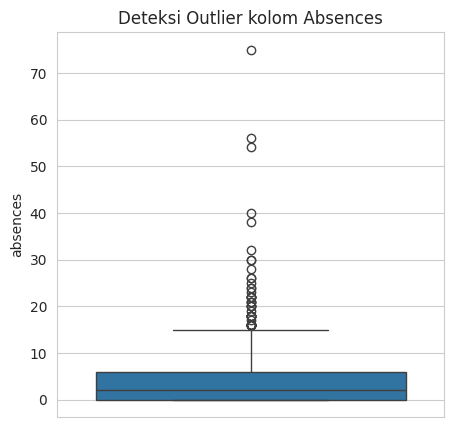

In [114]:
plt.figure(figsize=(5, 5))
sns.boxplot(df['absences'])
plt.title("Deteksi Outlier kolom Absences")
plt.show()

In [115]:
df_non_zero = df[df['absences'] > 0]

# Lanjut Hitung IQR dari Data yang Udah Disaring
Q1 = df_non_zero['absences'].quantile(0.25)
Q3 = df_non_zero['absences'].quantile(0.75)
IQR = Q3 - Q1

# Batas
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Lower Bound: 0
Upper Bound: 17.0


### Capping

In [116]:
# Batas Maksimum Outlier
maks_outlier = 17

# Capping Outlier
df['absences'] = df['absences'].clip(upper=maks_outlier)
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Pass,address_U,famsize_LE3,schoolsup_yes,paid_yes,activities_yes,higher_yes,internet_yes,sex_M,school_MS,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,romantic_yes,famsup_yes,nursery_yes,Pstatus_T
0,18,4,4,2,2,0,4,3,4,1,1,3,4,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,15,1,1,1,2,0,4,3,2,2,3,3,6,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
3,15,4,2,1,3,0,3,2,2,1,1,5,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1


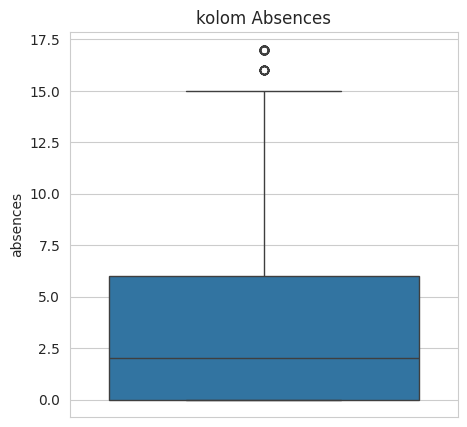

In [117]:
plt.figure(figsize=(5, 5))
sns.boxplot(df['absences'])
plt.title("kolom Absences")
plt.show()

### Feature Selection

In [118]:
threshold = 0.03
selected_features = target_corr[abs(target_corr) >= threshold].index

print("Fitur yang Dipilih:", selected_features.tolist())

# Data dengan fitur yang lolos threshold
X_selected = df[selected_features]


Fitur yang Dipilih: ['Pass', 'higher_yes', 'studytime', 'Medu', 'Fedu', 'reason_reputation', 'address_U', 'internet_yes', 'famsize_LE3', 'Mjob_health', 'famrel', 'Fjob_teacher', 'Mjob_teacher', 'Mjob_other', 'traveltime', 'health', 'schoolsup_yes', 'Fjob_services', 'freetime', 'paid_yes', 'Walc', 'romantic_yes', 'guardian_other', 'Dalc', 'goout', 'absences', 'school_MS', 'age', 'failures']


In [119]:
df_selected = df[selected_features]
df_selected.head()

,Pass,higher_yes,studytime,Medu,Fedu,reason_reputation,address_U,internet_yes,famsize_LE3,Mjob_health,famrel,Fjob_teacher,Mjob_teacher,Mjob_other,traveltime,health,schoolsup_yes,Fjob_services,freetime,paid_yes,Walc,romantic_yes,guardian_other,Dalc,goout,absences,school_MS,age,failures
0,1,1,2,4,4,0,1,0,0,0,4,1,0,0,2,3,1,0,3,0,1,0,0,1,4,4,0,18,0
1,1,1,2,1,1,0,1,1,0,0,5,0,0,0,1,3,0,0,3,0,1,0,0,1,3,2,0,17,0
2,1,1,2,1,1,0,1,1,1,0,4,0,0,0,1,3,1,0,3,0,3,0,0,2,2,6,0,15,0
3,1,1,3,4,2,0,1,1,0,1,3,0,0,0,1,5,0,1,2,0,1,1,0,1,2,0,0,15,0
4,1,1,2,3,3,0,1,0,0,0,4,0,0,1,1,5,0,0,3,0,2,0,0,1,2,0,0,16,0


In [120]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Pass               1044 non-null   int64
 1   higher_yes         1044 non-null   int64
 2   studytime          1044 non-null   int64
 3   Medu               1044 non-null   int64
 4   Fedu               1044 non-null   int64
 5   reason_reputation  1044 non-null   int64
 6   address_U          1044 non-null   int64
 7   internet_yes       1044 non-null   int64
 8   famsize_LE3        1044 non-null   int64
 9   Mjob_health        1044 non-null   int64
 10  famrel             1044 non-null   int64
 11  Fjob_teacher       1044 non-null   int64
 12  Mjob_teacher       1044 non-null   int64
 13  Mjob_other         1044 non-null   int64
 14  traveltime         1044 non-null   int64
 15  health             1044 non-null   int64
 16  schoolsup_yes      1044 non-null   int64
 17  Fjob_services 

### Scaling Fitur

In [121]:
# Setelah melakukan scaling dengan MinMaxScaler
scaler = MinMaxScaler()
kolom_scaling = ['age', 'absences']
df_selected[kolom_scaling] = scaler.fit_transform(df_selected[kolom_scaling])


df_selected.head().T


,0,1,2,3,4
Pass,1.000000,1.000000,1.000000,1.0,1.000000
higher_yes,1.000000,1.000000,1.000000,1.0,1.000000
studytime,2.000000,2.000000,2.000000,3.0,2.000000
Medu,4.000000,1.000000,1.000000,4.0,3.000000
Fedu,4.000000,1.000000,1.000000,2.0,3.000000
reason_reputation,0.000000,0.000000,0.000000,0.0,0.000000
address_U,1.000000,1.000000,1.000000,1.0,1.000000
internet_yes,0.000000,1.000000,1.000000,1.0,0.000000
famsize_LE3,0.000000,0.000000,1.000000,0.0,0.000000
Mjob_health,0.000000,0.000000,0.000000,1.0,0.000000


In [122]:
X = df_selected.drop(['Pass'], axis = 1)
y = df_selected['Pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Uji Coba Model

In [123]:
def evaluasi_model(models, X_train, X_test, y_train, y_test, models_to_save=None):
    hasil = []
    confusion_matrices = {}
    trained_models = {}
    for name, model in models.items():
        if isinstance(model, (BaseEstimator, CatBoostClassifier)):
            # Training model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if models_to_save and name in models_to_save:
                trained_models[name] = model

            # Evaluasi Model
            akurasi = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            confusion_matrices[name] = cm

            # Classification Report
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            hasil.append({
                'Model': name,
                'Akurasi': akurasi,
                'F1 Score': f1,
                'Precision Macro': report['macro avg']['precision'],
                'Recall Macro': report['macro avg']['recall'],
            })

            # Print Classification Report
            print(f"\n===== Classification Report untuk {name} =====")
            print(classification_report(y_test, y_pred, zero_division=0))

        else:
            print(f"Model {name} bukan estimator yang valid")

    df_hasil = pd.DataFrame(hasil)
    print("\n===== Hasil Evaluasi Model =====")
    print(tabulate(df_hasil, headers='keys', tablefmt='grid'))

    # Menampilkan Confusion Matrix untuk setiap model
    for name, cm in confusion_matrices.items():
        print(f"\nConfusion Matrix untuk {name}:")
        print(cm)

    # Simpan hanya model yang dipilih ke file pickle
    if trained_models:
        with open('selected_models.pkl', 'wb') as f:
            pickle.dump(trained_models, f)
        print("\nModel yang dipilih telah disimpan ke 'selected_models.pkl'")

    return df_hasil, confusion_matrices

# Inisialisasi model
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

models_to_save = ["Logistic Regression",'KNN', 'CatBoost']

hasil, confusion_matrices = evaluasi_model(models, X_train, X_test, y_train, y_test, models_to_save)


===== Classification Report untuk Logistic Regression =====
              precision    recall  f1-score   support

           0       0.69      0.20      0.31        46
           1       0.81      0.98      0.89       163

    accuracy                           0.80       209
   macro avg       0.75      0.59      0.60       209
weighted avg       0.79      0.80      0.76       209


===== Classification Report untuk KNN =====
              precision    recall  f1-score   support

           0       0.69      0.20      0.31        46
           1       0.81      0.98      0.89       163

    accuracy                           0.80       209
   macro avg       0.75      0.59      0.60       209
weighted avg       0.79      0.80      0.76       209


===== Classification Report untuk Decision Tree =====
              precision    recall  f1-score   support

           0       0.31      0.35      0.33        46
           1       0.81      0.78      0.79       163

    accuracy         

Dari hasil modeling diatas, dapat dilihat melalui F1-score dan corelation matrix bahwa hasil prediksi sangat imbalance antara 0 (Mengulang), dan 1(Lulus). Oleh karena itu diperlukan preprocessing lebih lanjut